# Transition Path Theory applied to triplewell dynamics

Based on: 
Extending Transition Path Theory: Periodically-Driven and Finite-Time Dynamics. [arXiv preprint arXiv:2002.07474.](https://arxiv.org/pdf/2002.07474.pdf)  


In [1]:
from pytpt import stationary  
from pytpt import periodic  
from pytpt import finite  
from plotting import plot_3well, \
                     plot_3well_effcurrent, \
                     plot_3well_potential, \
                     plot_3well_vector_field
import numpy as np
import os.path

In [2]:
# define directories path to save the data and figures 
my_path = os.path.abspath('')
data_path = os.path.join(my_path, 'data')
file_path = None

# Stationary, infinite-time process

given by $dX_t = - \nabla V(X_t) dt + \sigma dW_t$, below we show the energy landscape $V(x,y)$

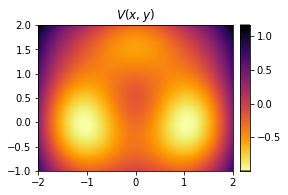

In [3]:
#triple well in 2D energy landscape V and gradient dV
factor = 0.25
V = lambda x, y: 1 * factor*(3*np.exp(-x**2-(y-(1./3))**2) \
                - 3*np.exp(-x**2-(y-(5./3))**2) - 5*np.exp(-(x-1)**2-y**2) \
                - 5*np.exp(-(x+1)**2-y**2)  + 0.2*(x**4) + 0.2*(y-1./3)**4)
 

# plot potential and gradient
title = 'Triple well Potential'
subtitles=[
    r'$V(x, y)$', 
]
plot_3well_potential(
    potential=V,
    title=title,
    file_path=None,
    subtitles=subtitles,
)

To apply TPT to these dynamics, we estimated a transition matrix $T$ on a discrete grid on $[-2,2]\times[-1,2]$. 
As sets A and B we chose the two deep wells of the energy landscape.

In [4]:
# load triple well data
triplewell_construction = np.load(
    os.path.join(data_path, 'triplewell_construction.npz'),
    allow_pickle=True,
)

interval = triplewell_construction['interval']
dx = triplewell_construction['dx']
ind_A = triplewell_construction['ind_A']
ind_B = triplewell_construction['ind_B']
ind_C = triplewell_construction['ind_C']
T = triplewell_construction['T']
T_m = triplewell_construction['T_m']

#state space
x = np.arange(interval[0,0], interval[0,1] + dx, dx) #box centers in x and y direction
y = np.arange(interval[1,0], interval[1,1] + dx, dx)
xv, yv = np.meshgrid(x, y)

xdim = np.shape(xv)[0] #discrete dimension in x and y direction
ydim = np.shape(xv)[1]
dim_st = xdim * ydim # dimension of the statespace
xn = np.reshape(xv, (xdim * ydim, 1))
yn = np.reshape(yv, (xdim * ydim, 1))
grid = np.squeeze(np.array([xn, yn]))

We instantiate the TPT class ``stationary.tpt``for the stationary case using the (row-stochastic and irreducible) transition matrix $T$ and index sets of $A$, $B$, and $C$ (``ind_A, ind_B, ind_C``). 
Then we can compute the various statistics of the ensemble of trajectory pieces that start in $A$ and end in $B$.

In [5]:
# instantiate
well3 = stationary.tpt(T, ind_A, ind_B, ind_C)
# compute statistics
well3.compute_statistics()

The stationary density of the process is given by $\pi^\top = P \pi^\top$ and indicates that the process spends most of the time in the two deep wells centered at $(-1,0)$ and $(1,0)$ and sometimes visits the lower well at $(0,1.5)$.

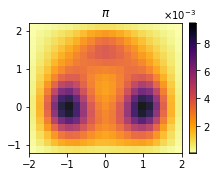

In [6]:
stat_dens = well3._stat_dens

# plotting
data = np.array([stat_dens])
v_min = np.nanmin(data)
v_max = np.nanmax(data)
plot_3well(data, (xdim, ydim), (interval[0,0], interval[0,1], interval[1,0], interval[1,1]), 1, (3*1,3), v_min, v_max, ['$\pi$'], file_path=file_path)

Then we can have a look at the committor functions, the forward committor $q^+$ gives the probability that the process next visits $B$ and not $A$, while the backward committor $q-$ gives the probability that the process last came from $A$ and not $B$.
The committors can be computed from the following linear systems
\begin{equation}  
\left\{ \begin{array}{rcll}
q_i^+ &=& \sum_{j\in \mathbb{S}} \, T_{ij} \, q_j^+ &i \in C,   \\
    q_i^+ &=& 0& i \in A,  \\
    q_i^+ &=& 1& i \in B,  \\
\end{array}\right.
\end{equation}
and 
\begin{equation}  
\left\{ \begin{array}{rcll}
q_i^- &=& \sum_{j\in \mathbb{S}} \, T^-_{ij} \, q_j^- &i \in C,   \\
    q_i^- &=& 0& i \in B,  \\
    q_i^- &=& 1& i \in A,  \\
\end{array}\right.
\end{equation}
where $\mathbb{S}$ is the statespace and $T^-$ the time-reversed transition matrix.

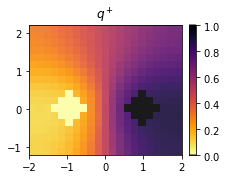

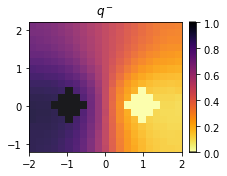

In [7]:
q_f = well3._q_f
q_b = well3._q_b

# plotting
data = np.array([q_f])
v_min = np.nanmin(data)
v_max = np.nanmax(data)
plot_3well(data, (xdim,ydim), (interval[0,0],interval[0,1], interval[1,0], interval[1,1]), 1, (3*1,3), v_min, v_max, ['$q^+$'],  file_path=file_path)

data = np.array([q_b])
v_min = np.nanmin(data)
v_max = np.nanmax(data)
plot_3well(data, (xdim,ydim), (interval[0,0],interval[0,1],interval[1,0],interval[1,1]), 1, (3*1,3), v_min, v_max, ['$q^-$'],  file_path=file_path)

The (normalized) density of reactive trajectories can then be found as  $\hat{\mu}_i^{AB} = \frac{1}{Z^{AB}} q_i^- q_i^+ \pi_i$ ($Z^{AB}$ is the normalization constant) and shows where the trajectory spends most of their time while transitioning from $A$ to $B$.

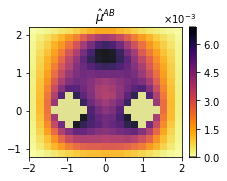

In [8]:
norm_reac_dens = well3._norm_reac_dens

# plotting

# to highlight the sets A and B
densAB = np.zeros(dim_st); densAB[ind_A] = 1; densAB[ind_B] = 1

data = np.array([norm_reac_dens])
v_min = np.nanmin(data)
v_max = np.nanmax(data)
plot_3well(data, (xdim,ydim), (interval[0,0],interval[0,1],interval[1,0],interval[1,1]) , 1, (3*1,3), v_min, v_max, ['$\hat{\mu}^{AB}$'],  file_path=file_path, background=densAB)

The current of reactive trajectories is given by $f_{ij}^{AB} = q_i^- \pi_i T_{ij}q_j^+$, here we plot the vector field of the effective current $f^+_{ij} = \max\left(0, f_{ij}^{AB}-f_{ji}^{AB}\right)$ indicating where the reactive trajectories are effectively happening.

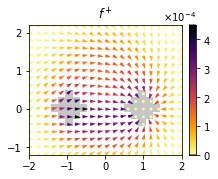

In [9]:
eff_current = well3._eff_current

# plotting

# calculation the effective vector for each state
eff_vectors = np.zeros((dim_st, 2))
eff_vectors_unit = np.zeros((dim_st, 2))
colors = np.zeros(dim_st)
for i in np.arange(dim_st):
    for j in np.arange(dim_st):
        if np.linalg.norm(np.array([xn[j] - xn[i], yn[j] - yn[i]])) > 0:
            eff_vectors[i,0] += eff_current[i,j] *  (xn[j] - xn[i])  *(1/np.linalg.norm(np.array([xn[j] - xn[i],yn[j] - yn[i]]))) 
            eff_vectors[i,1] += eff_current[i,j] *  (yn[j] - yn[i])  *(1/np.linalg.norm(np.array([xn[j] - xn[i],yn[j] - yn[i]]))) 
    colors[i] = np.linalg.norm(eff_vectors[i,:])
    if colors[i] > 0:
        eff_vectors_unit[i,:] = eff_vectors[i,:]/colors[i] 
            
plot_3well_effcurrent(np.array([eff_vectors_unit]), np.array([colors]), xn, yn, densAB, (xdim, ydim), (interval[0,0], interval[0,1], interval[1,0], interval[1,1]), 1, (3*1, 3), ['$f^+$'],  file_path=file_path)

Last, we give the rate of trajectories leaving $A$ as well as the mean transition length from $A$ to $B$.

In [10]:
rate = well3._rate
length = well3._length

print("rate: %f" % rate)
print("mean length: %f" % length)

rate: 0.014213
mean length: 10.015580


# Periodically-forced process

given by $dX_t =( - \nabla V(X_t) + F(X_t, t) ) dt + \sigma dW_t$ which adds an anti-clockwise, periodic circulation $F(x,t)$ to the triplewell dynamics from the above example.

To apply TPT, we again estimate a transition matrix from the continuous process, but this time the transition matrix varies periodically with period $M=6$.

We instanstiate the class ``periodic.tpt`` with a function that maps the time point $m$ to the corresponding transition matrix $T_m$, the length of the period $M$, as well as the index sets of $A$, $B$ and $C$.

In [11]:
M = np.shape(T_m)[0] # length of period 

def Tm(m): 
    return T_m[np.mod(m, M), :, :].squeeze()

# instantiate
well3_periodic = periodic.tpt(Tm, M, ind_A, ind_B, ind_C)
# compute statistics
well3_periodic.compute_statistics()

The periodically-varying, equilibrated density is shown for the different time instances during one period.

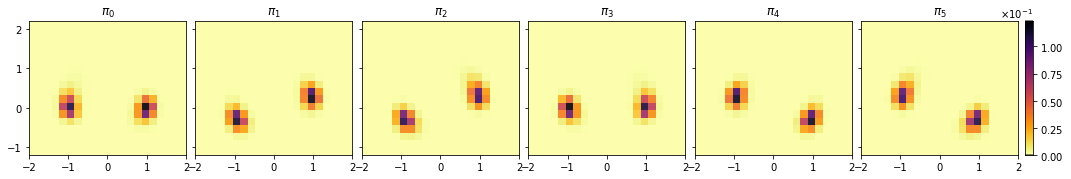

In [12]:
stat_dens_p = well3_periodic._stat_dens

# plotting
def subtitles_m(quant,M):
    return np.array([quant.format(str(i)) for i in np.arange(M)])

data = stat_dens_p
v_min = np.nanmin(data)
v_max = np.nanmax(data)
plot_3well(data, (xdim,ydim), (interval[0,0], interval[0,1], interval[1,0], interval[1,1]), M, (3*M,3), v_min, v_max, subtitles_m('$\pi_{}$', M),  file_path=file_path) 


Then we can give the committors which are now also depending on the time point $m$ within the period.

\begin{equation} 
\left\{ \begin{array}{rcll}
q_{m,i}^+ &=& \sum_{j\in \mathbb{S}} \, T_{m,ij} \, q_{m+1,j}^+ & i \in (A\cup B)^c, \\
    q_{m,i}^+ &=& 0& i \in A,  \\
    q_{m,i}^+ &=& 1& i \in B,  \\
\end{array}\right.
\end{equation}
and analogously for the backward committor.

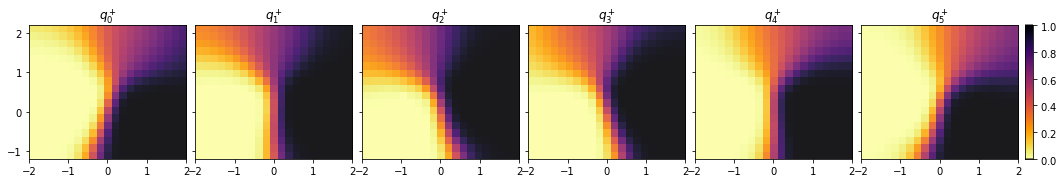

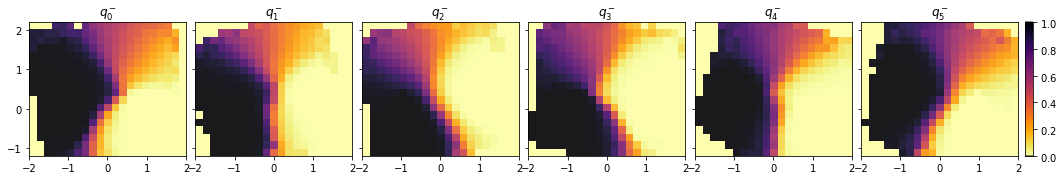

In [13]:
q_f_p = well3_periodic._q_f
q_b_p = well3_periodic._q_b

# plotting
data = q_f_p
v_min = np.nanmin(data)
v_max = np.nanmax(data)
plot_3well(data, (xdim,ydim), (interval[0,0], interval[0,1], interval[1,0], interval[1,1]), M, (3*M,3), v_min, v_max, subtitles_m('$q^+_{}$', M), file_path=file_path)

data = q_b_p
v_min = np.nanmin(data)
v_max = np.nanmax(data)
plot_3well(data, (xdim,ydim), (interval[0,0], interval[0,1], interval[1,0], interval[1,1]), M, (3*M,3), v_min, v_max, subtitles_m('$q^-_{}$', M), file_path=file_path)


The transition statistics such as the density of reactive trajectories $\hat{\mu}_m^{AB}$ and the effective current of reactive trajectories $f^+_m$ vary within the period and show how the circular forcing influences the transition pathways.

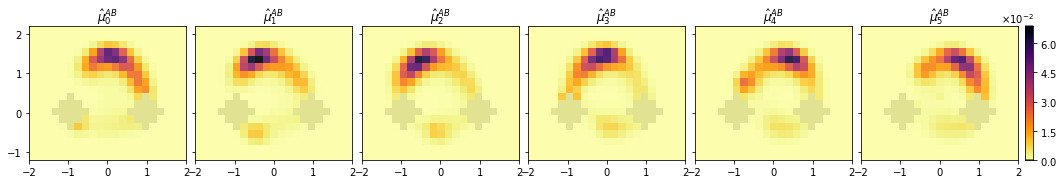

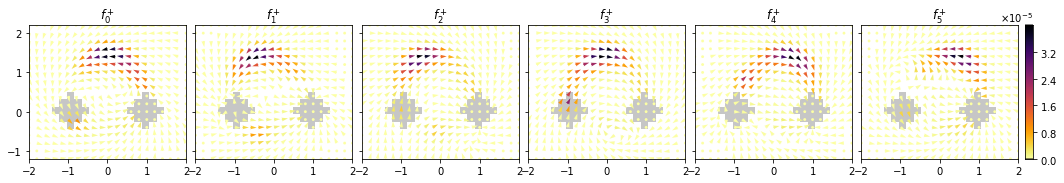

In [14]:
norm_reac_dens_p = well3_periodic._norm_reac_dens

# plotting
data = norm_reac_dens_p
v_min = np.nanmin(data)
v_max = np.nanmax(data)
plot_3well(data, (xdim,ydim), (interval[0,0], interval[0,1], interval[1,0], interval[1,1]), M, (3*M,3), v_min, v_max,np.array(['$\hat{\mu}^{AB}_0$','$\hat{\mu}^{AB}_1$','$\hat{\mu}^{AB}_2$','$\hat{\mu}^{AB}_3$','$\hat{\mu}^{AB}_4$','$\hat{\mu}^{AB}_5$']), file_path=file_path, background=densAB) 

eff_current_p = well3_periodic._eff_current

# plotting
# calculation the effective vector for each state
eff_vectors_p = np.zeros((M, dim_st, 2))
eff_vectors_unit_p = np.zeros((M, dim_st, 2))
colors_p = np.zeros((M, dim_st))
for m in np.arange(M):
    for i in np.arange(dim_st):
        for j in np.arange(dim_st):
            if np.linalg.norm(np.array([xn[j] - xn[i], yn[j] - yn[i]])) > 0:
                eff_vectors_p[m,i,0] += eff_current_p[m,i,j] *  (xn[j] - xn[i])  *(1/np.linalg.norm(np.array([xn[j] - xn[i],yn[j] - yn[i]]))) 
                eff_vectors_p[m,i,1] += eff_current_p[m,i,j] *  (yn[j] - yn[i])  *(1/np.linalg.norm(np.array([xn[j] - xn[i],yn[j] - yn[i]]))) 
        colors_p[m,i] = np.linalg.norm(eff_vectors_p[m,i,:])
        if colors_p[m,i]>0:
            eff_vectors_unit_p[m,i,:] = eff_vectors_p[m,i,:]/colors_p[m,i]
 

plot_3well_effcurrent(eff_vectors_unit_p, colors_p, xn, yn, densAB, (xdim,ydim), (interval[0,0], interval[0,1], interval[1,0], interval[1,1]), M, (3*M,3), subtitles_m('$f^+_{}$', M), file_path=file_path) 

We can compare the averaged rate of reactive trajectories leaving $A$ and the mean transition length with the same quantities from the non-forced process above to note that the forcing increases the likelihood of $AB$ transitions.

In [15]:
time_av_rate_p = well3_periodic._time_av_rate
av_length_p = well3_periodic._av_length

print("periodic-averaged rate: %f" % time_av_rate_p[0])
print("mean length: %f" % av_length_p)

periodic-averaged rate: 0.000031
mean length: 27.336051


# Finite-time transitions

We consider again the stationary motion in the triplewell landscape, but restrict transitions to a finite-time interval $[0,N]$.

We instantiate the class ``finite.tpt`` with the function ``Tn`` that maps time $n$ to the corresponding transition matrix (possibly time-dependent, here not), the length of the time interval, the index sets and the initial density at time $n=0$ (here the stationary density of the infinite-time process).

In [16]:
def Tn(n):  
    return T

N = 6 #time window

# initial density
init_dens_well3_finite = well3._stat_dens
# instantiate
well3_finite = finite.tpt(Tn, N, ind_A, ind_B, ind_C, init_dens_well3_finite)
# compute statistics
well3_finite.compute_statistics()

The committor equations are now iterative equations in time, backward in time for the forward committor $q^+(n)$ and forward in time for the backward committor $q^-(n)$. 
\begin{equation}  
\left\{ \begin{array}{rcll}
q_i^+(n) &=&  
\sum_{j \in \mathbb{S}} \, T_{n,ij} \, q_j^+(n+1)    & i \in (A\cup B)^c,  \\
q_i^+(n) &=& 0 & i \in A, \\
q_i^+(n) &=& 1 & i \in B,
\end{array}\right.
\end{equation}

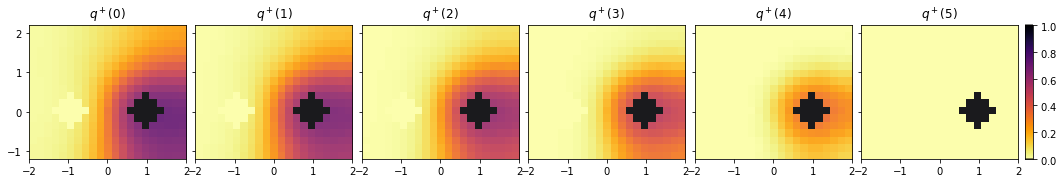

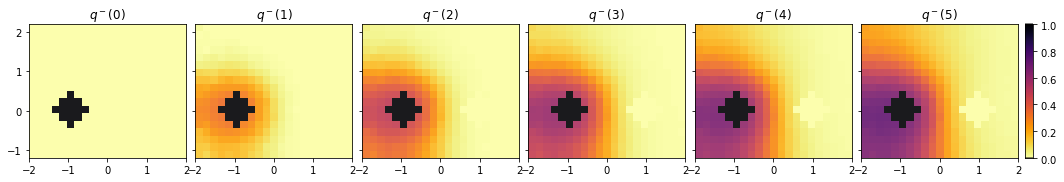

In [17]:
q_f_f = well3_finite._q_f
q_b_f = well3_finite._q_b

# plotting
data = q_f_f
v_min = np.nanmin(data)
v_max = np.nanmax(data)
plot_3well(data, (xdim,ydim), (interval[0,0], interval[0,1], interval[1,0], interval[1,1]), N, (3*N,3), v_min, v_max, subtitles_m('$q^+({})$',N), file_path=file_path)

data = q_b_f
v_min = np.nanmin(data)
v_max = np.nanmax(data)
plot_3well(data, (xdim,ydim), (interval[0,0], interval[0,1], interval[1,0], interval[1,1]), N, (3*N,3), v_min, v_max, subtitles_m('$q^-({})$',N), file_path=file_path)

We can again show the time-dependent transition statistics.

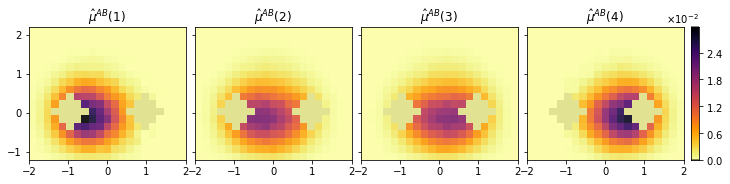

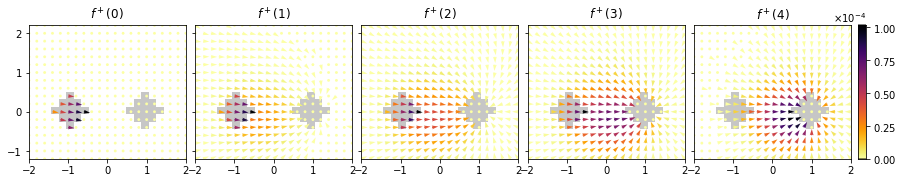

In [18]:
norm_reac_dens_f = well3_finite._norm_reac_dens
eff_current_f = well3_finite._eff_current

# plotting
data = norm_reac_dens_f
v_min = np.nanmin(data)
v_max = np.nanmax(data)
plot_3well(data[1:N-1,:], (xdim,ydim), (interval[0,0], interval[0,1], interval[1,0], interval[1,1]), N-2, (3*(N-2),3), v_min, v_max, np.array(['$\hat{\mu}^{AB}(1)$','$\hat{\mu}^{AB}(2)$','$\hat{\mu}^{AB}(3)$','$\hat{\mu}^{AB}(4)$']), file_path=file_path, background=densAB) 

# calculation the effective vector for each state
eff_vectors_f = np.zeros((N,dim_st, 2))
eff_vectors_unit_f = np.zeros((N,dim_st, 2))
colors_f = np.zeros((N,dim_st))
for n in np.arange(N):
    for i in np.arange(dim_st):
        for j in np.arange(dim_st):
            # if np.isnan(eff_current_f[n,i,j])==False:

            if np.linalg.norm(np.array([xn[j] - xn[i],yn[j] - yn[i]]))>0:
                eff_vectors_f[n,i,0] += eff_current_f[n,i,j] *  (xn[j] - xn[i])  *(1/np.linalg.norm(np.array([xn[j] - xn[i],yn[j] - yn[i]]))) 
                eff_vectors_f[n,i,1] += eff_current_f[n,i,j] *  (yn[j] - yn[i])  *(1/np.linalg.norm(np.array([xn[j] - xn[i],yn[j] - yn[i]]))) 
        colors_f[n,i] = np.linalg.norm(eff_vectors_f[n,i,:])
        if colors_f[n,i]>0:
            eff_vectors_unit_f[n,i,:] = eff_vectors_f[n,i,:]/colors_f[n,i]
            

plot_3well_effcurrent(eff_vectors_unit_f[:N-1,:,:], colors_f[:N-1,:], xn, yn, densAB,(xdim,ydim), (interval[0,0],interval[0,1],interval[1,0],interval[1,1]), N-1, (3*(N-1),3), subtitles_m('$f^+({})$',N-1), file_path=file_path)

And consider the time-averaged rate of transitions leaving $A$, which is now much smaller than in the infinite-time case since only a subset of transitions is considered, namely, those that happen within $[0,N]$. The mean length of transitions thus also has an upper limit of $N$.

In [19]:
time_av_rate_f = well3_finite._time_av_rate
av_length_f = well3_finite._av_length

print("time-averaged rate (finite-time, time-homogeneous): %f" % time_av_rate_f[0])
print("mean length (finite-time, time-homogeneous): %f" % av_length_f)

time-averaged rate (finite-time, time-homogeneous): 0.001674
mean length (finite-time, time-homogeneous): 2.064542
